# Stacking Ensemble Model

# 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score)

import pickle
import time
import os

In [2]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [3]:
print("Notebook 11: Stacking Ensemble Model ")

Notebook 11: Stacking Ensemble Model 


# 2. Load Prepared Datasets

Load training and testing sets

In [36]:
X_train = np.load("../data/processed/ml_ready/X_train_scaled.npy")
X_test = np.load("../data/processed/ml_ready/X_test_scaled.npy")
y_train = np.load("../data/processed/ml_ready/y_train.npy")
y_test = np.load("../data/processed/ml_ready/y_test.npy")

Load feature names and label encoder

In [5]:
with open("../data/processed/ml_ready/feature_names.pkl", "rb") as f:
    feature_names = pickle.load(f)

with open("../models/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


In [6]:
print(f"Training samples:{X_train.shape[0]:,}")
print(f"Testing samples: {X_test.shape[0]:,}")
print(f"Number of features: {X_train.shape[1]:,}")
print(f"Classes: {len(label_encoder.classes_)} which are {list(label_encoder.classes_)}")

Training samples:1,760
Testing samples: 440
Number of features: 39
Classes: 22 which are ['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 'coffee', 'cotton', 'grapes', 'jute', 'kidneybeans', 'lentil', 'maize', 'mango', 'mothbeans', 'mungbean', 'muskmelon', 'orange', 'papaya', 'pigeonpeas', 'pomegranate', 'rice', 'watermelon']


# 4. Load Pre-trained Models (Optional Comparison)

In [8]:
print("\n Loading previously trained models for comparison...")

with open('../models/random_forest_model.pkl','rb') as f:
    rf_pretrained = pickle.load(f)
    
with open('../models/boosting_models/xgboost_model.pkl','rb') as f:
    xgb_pretrained = pickle.load(f)
    
with open('../models/boosting_models/lightgbm_model.pkl', 'rb') as f:
    lgbm_pretrained = pickle.load(f)


 Loading previously trained models for comparison...


Get individual model accuracies

In [9]:
rf_acc=accuracy_score(y_test, rf_pretrained.predict(X_test))
xgb_acc= accuracy_score(y_test, xgb_pretrained.predict(X_test))
lgbm_acc= accuracy_score(y_test, lgbm_pretrained.predict(X_test))

c:\Users\Prathamesh Gawas\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [10]:
print("Individual Model Accuracies:")
print(f"Random Forest Accuracy: {rf_acc*100:.2f} %")
print(f"XGBoost Accuracy: {xgb_acc*100:.2f} %")
print(f"LightGBM Accuracy: {lgbm_acc*100:.2f} %")
print(f"Best Individual Model Accuracy: {max(rf_acc, xgb_acc, lgbm_acc)*100:.2f}%")

Individual Model Accuracies:
Random Forest Accuracy: 99.32 %
XGBoost Accuracy: 98.64 %
LightGBM Accuracy: 98.41 %
Best Individual Model Accuracy: 99.32%


# 5.Define Base Estimators (Level 0)

In [12]:
print("Defining base learners for stacking ensemble...")

Defining base learners for stacking ensemble...


Random Forest - with best parameters from previous training

In [14]:
rf_base=RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

XGBoost - with best parameters from Notebook 10

In [15]:
n_classes=len(np.unique(y_train))

xgb_base=XGBClassifier(
    learning_rate=0.05,
    max_depth=6,
    n_estimators=300,
    objective='multi:softprob',
    num_class=n_classes,
    subsamples=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

LightGBM - with best parameters from Notebook 10

In [16]:
lgbm_base=LGBMClassifier(
    num_leaves=20,
    learning_rate=0.1,
    n_estimators=100,
    objective='multiclass',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# 6. Define Meta-Learner (Level 1)

In [17]:
print("Defining meta learner (Level-1 model)...")

Defining meta learner (Level-1 model)...


Logistic Regression as meta-learner

In [27]:
meta_learner = LogisticRegression(
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
)

# 7. Build Stacking Classifier

In [28]:
print("Building Stacking Ensemble Classifier...")

Building Stacking Ensemble Classifier...


Define base estimators as list of tuples

In [29]:
base_estimators=[
    ("rf",rf_base),
    ("xgb",xgb_base),
    ("lgbm",lgbm_base)
]

Create Stacking Classifier

In [30]:
stacking_model=StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1,
    passthrough=False,
    verbose=0
)

In [31]:
print("Stacking Configuration")
print(f"Base Estimators: {len(base_estimators)} (RF, XGBoost, LightGBM)")
print("Meta Learner: Logistic Regression")
print("Cross_Validation Folds: 5")
print("Stack Method: predict_proba")
print(f"Meta Features:{n_classes*3} (22 classes x 3 base models)")

Stacking Configuration
Base Estimators: 3 (RF, XGBoost, LightGBM)
Meta Learner: Logistic Regression
Cross_Validation Folds: 5
Stack Method: predict_proba
Meta Features:66 (22 classes x 3 base models)


# 8. Train Stacking Ensemble

In [32]:
print("Training in progress...")
print("This may take a while depending on your hardware...")
start_time = time.time()
stacking_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


Training in progress...
This may take a while depending on your hardware...
Training completed in 30.43 seconds (0.51 minutes)


# 9. Make Predictions

In [34]:
print("Making predictions on train and test sets...")

Making predictions on train and test sets...


Predictions on training set

In [39]:
start_time=time.time()
y_train_pred=stacking_model.predict(X_train)
y_train_proba=stacking_model.predict_proba(X_train)
train_pred_time=time.time()- start_time

c:\Users\Prathamesh Gawas\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Prathamesh Gawas\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Predictions on test set

In [40]:
start_time = time.time()
y_test_pred=stacking_model.predict(X_test)
y_test_proba=stacking_model.predict_proba(X_test)
test_pred_time=time.time() - start_time

c:\Users\Prathamesh Gawas\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Prathamesh Gawas\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [41]:
print(f"Training set prediction time: {train_pred_time:.4f} seconds")
print(f"Test set prediction time: {test_pred_time:.4f} seconds")
print(f"Avg prediction time per sample: {test_pred_time/len(y_test)*1000:.4f} ms")

Training set prediction time: 0.2293 seconds
Test set prediction time: 0.5275 seconds
Avg prediction time per sample: 1.1989 ms


# 10. Evaluate Performance

In [42]:
print("STACKING ENSEMBLE PERFORMANCE")

STACKING ENSEMBLE PERFORMANCE


Training metrics

In [44]:
train_accuracy=accuracy_score(y_train, y_train_pred)
train_precision=precision_score(y_train, y_train_pred, average='weighted')
train_recall=recall_score(y_train, y_train_pred, average='weighted')
train_f1=f1_score(y_train, y_train_pred, average='weighted')

Test metrics

In [45]:
test_accuracy=accuracy_score(y_test, y_test_pred)
test_precision=precision_score(y_test, y_test_pred, average='weighted')
test_recall=recall_score(y_test, y_test_pred, average='weighted')
test_f1=f1_score(y_test, y_test_pred, average='weighted')

Overfitting analysis

In [46]:
overfitting_gap = train_accuracy - test_accuracy

In [47]:
print("Training Set Peformance:")
print(f"Accuracy: {train_accuracy*100:.2f} %")
print(f"Precision: {train_precision*100:.2f} %")
print(f"Recall: {train_recall*100:.2f} %")
print(f"F1-Score: {train_f1*100:.2f} %")

Training Set Peformance:
Accuracy: 100.00 %
Precision: 100.00 %
Recall: 100.00 %
F1-Score: 100.00 %


In [48]:
print(f"Test Set Performance:")
print(f"Accuracy: {test_accuracy*100:.2f} %")
print(f"Precision: {test_precision*100:.2f} %")
print(f"Recall: {test_recall*100:.2f} %")
print(f"F1-Score: {test_f1*100:.2f} %")

Test Set Performance:
Accuracy: 99.32 %
Precision: 99.37 %
Recall: 99.32 %
F1-Score: 99.32 %


In [49]:
print("Overfitting Analysis:")
print(f"Overfitting Gap (Train Accuracy - Test Accuracy): {overfitting_gap*100:.2f} %")

Overfitting Analysis:
Overfitting Gap (Train Accuracy - Test Accuracy): 0.68 %


In [50]:
if overfitting_gap<0.02:
    print("Status:Excellent - Minimal Overfitting")
elif overfitting_gap<0.05:
    print("Status:Good - Acceptable Overfitting")
else:
    print("Status: Warning - Consider regularization")

Status:Excellent - Minimal Overfitting


Check if target achieved

In [51]:
target_accuracy = 0.98
if test_accuracy>=target_accuracy:
    print(f"\nTARGET ACHIEVED! Accuracy:{test_accuracy*100:.2f}% >= 98%")
    print("The Stacking Ensemble meets the target requirement!")
else:
    print(f"\nTarget not reached. Accuracy: {test_accuracy*100:.2f}% < 98%")
    print(f"Gap to target: {(target_accuracy - test_accuracy)*100:.2f}%")


TARGET ACHIEVED! Accuracy:99.32% >= 98%
The Stacking Ensemble meets the target requirement!


# 11. Compare with Individual Models

In [59]:
print("Model Comparison: Stacking vs Individual Models")

def parse_accuracy(val):
    if isinstance(val, str):
        return float(val.replace('%', ''))
    return float(val) * 100 if val <= 1 else float(val)

try:
    lr_summary = pd.read_csv('../data/results/logistic_regression_summary.csv')
    dt_summary = pd.read_csv('../data/results/decision_tree_summary.csv')
    svm_summary = pd.read_csv('../data/results/svm_summary.csv')

    comparison_df = pd.DataFrame({
        'Model': [
            'Logistic Regression',
            'Decision Tree',
            'Random Forest',
            'SVM',
            'XGBoost',
            'LightGBM',
            'STACKING ENSEMBLE'
        ],
        'Test Accuracy': [
            parse_accuracy(lr_summary['Test_Accuracy'].values[0]),
            parse_accuracy(dt_summary['Test_Accuracy'].values[0]),
            rf_acc * 100,
            parse_accuracy(svm_summary['Test_Accuracy'].values[0]),
            xgb_acc * 100,
            lgbm_acc * 100,
            test_accuracy * 100
        ]
    })

    comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
    comparison_df['Rank'] = range(1, len(comparison_df) + 1)
    comparison_df['Test Accuracy'] = comparison_df['Test Accuracy'].apply(
        lambda x: f"{x:.2f}%"
    )

    print("\n")
    print(comparison_df[['Rank', 'Model', 'Test Accuracy']].to_string(index=False))

except Exception as e:
    print(f"Could not load all previous results: {e}")
    print("\nDirect comparison with base models:")
    print(f"Random Forest:{rf_acc*100:.2f}%")
    print(f"XGBoost:{xgb_acc*100:.2f}%")
    print(f"LightGBM:{lgbm_acc*100:.2f}%")
    print(f"STACKING:{test_accuracy*100:.2f}%")

Model Comparison: Stacking vs Individual Models


 Rank               Model Test Accuracy
    1       Random Forest        99.32%
    2   STACKING ENSEMBLE        99.32%
    3             XGBoost        98.64%
    4            LightGBM        98.41%
    5                 SVM        97.95%
    6 Logistic Regression        97.73%
    7       Decision Tree        95.68%


# 12. Confusion Matrix Visualization

In [60]:
cm=confusion_matrix(y_test, y_test_pred)
cm_normalized=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]

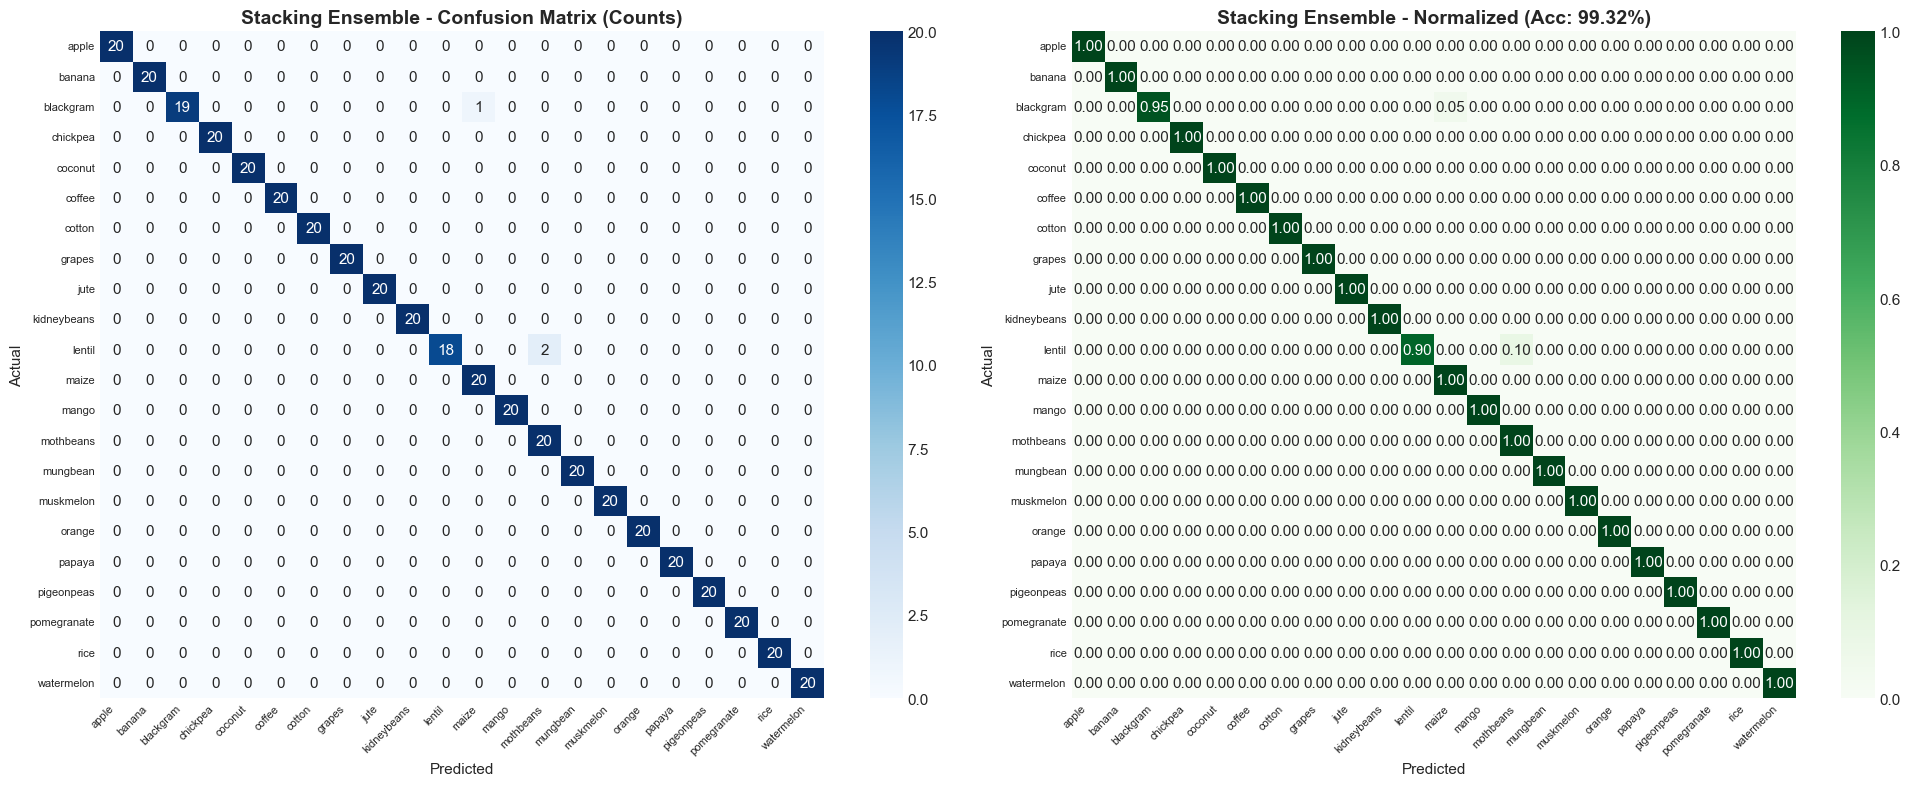

Saved: ../data/visualizations/46_stacking_confusion_matrix.png


In [62]:
fig,axes=plt.subplots(1,2,figsize=(20,8))

sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[0])

axes[0].set_title('Stacking Ensemble - Confusion Matrix (Counts)', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].tick_params(axis='both', labelsize=8)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title(f'Stacking Ensemble - Normalized (Acc: {test_accuracy*100:.2f}%)', 
                  fontweight='bold', fontsize=14)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].tick_params(axis='both', labelsize=8)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../data/visualizations/46_stacking_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: ../data/visualizations/46_stacking_confusion_matrix.png")

# 13. Per-Class Performance Analysis

Classification Report

In [63]:
print("Per class performance metrics:")
report = classification_report(y_test, y_test_pred, 
                               target_names=label_encoder.classes_,
                               output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df.round(4).to_string())

Per class performance metrics:
              precision  recall  f1-score   support
apple            1.0000  1.0000    1.0000   20.0000
banana           1.0000  1.0000    1.0000   20.0000
blackgram        1.0000  0.9500    0.9744   20.0000
chickpea         1.0000  1.0000    1.0000   20.0000
coconut          1.0000  1.0000    1.0000   20.0000
coffee           1.0000  1.0000    1.0000   20.0000
cotton           1.0000  1.0000    1.0000   20.0000
grapes           1.0000  1.0000    1.0000   20.0000
jute             1.0000  1.0000    1.0000   20.0000
kidneybeans      1.0000  1.0000    1.0000   20.0000
lentil           1.0000  0.9000    0.9474   20.0000
maize            0.9524  1.0000    0.9756   20.0000
mango            1.0000  1.0000    1.0000   20.0000
mothbeans        0.9091  1.0000    0.9524   20.0000
mungbean         1.0000  1.0000    1.0000   20.0000
muskmelon        1.0000  1.0000    1.0000   20.0000
orange           1.0000  1.0000    1.0000   20.0000
papaya           1.0000  1.0000  

Per-class F1-scores visualization

In [64]:
class_names=label_encoder.classes_
f1_scores=[report[cls]["f1-score"] for cls in class_names]

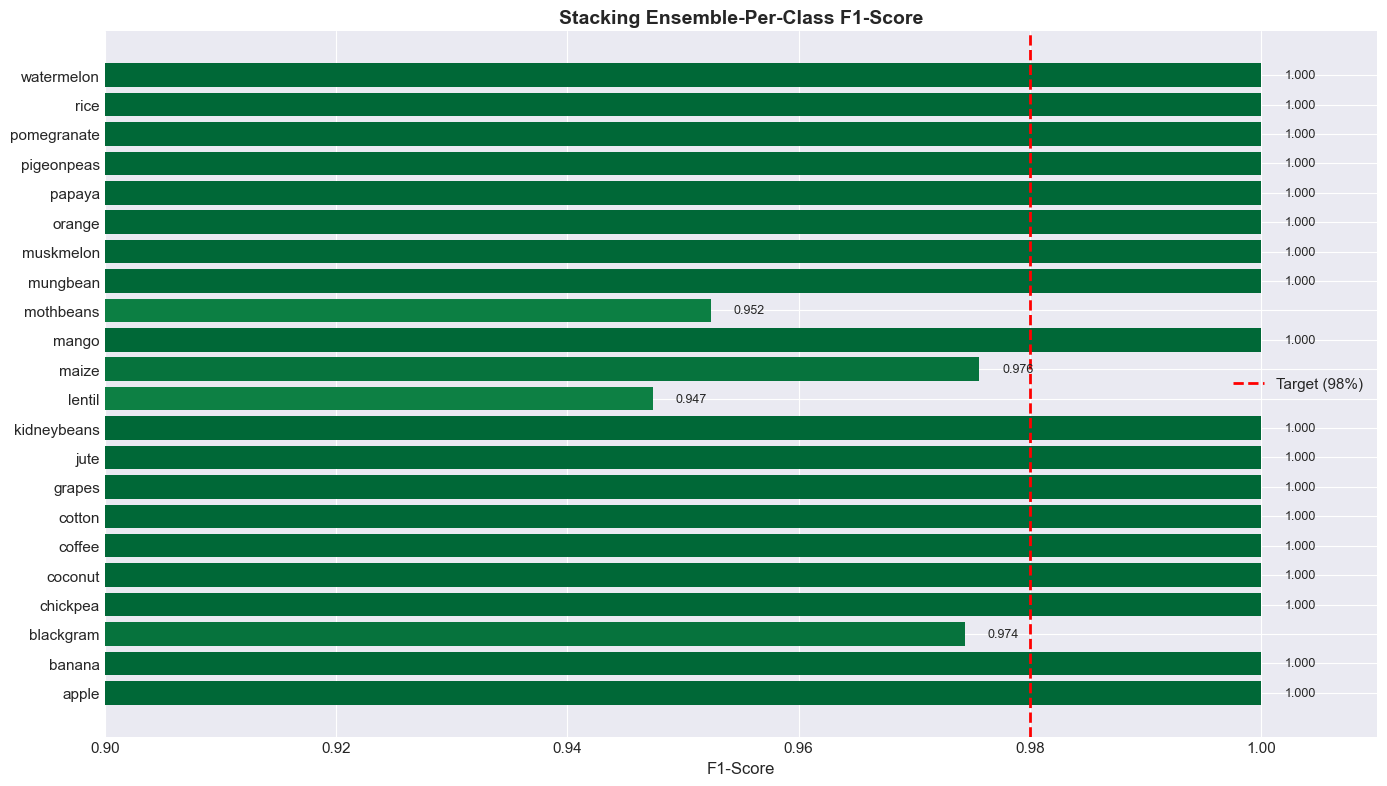

Saved: ../data/visualizations/47_stacking_per_class_f1.png


In [65]:
fig,ax=plt.subplots(figsize=(14,8))
colors = plt.cm.RdYlGn(np.array(f1_scores))
bars = ax.barh(class_names, f1_scores, color=colors)
ax.axvline(x=0.98, color='red', linestyle='--', linewidth=2, label='Target (98%)')
ax.set_xlim(0.9, 1.01)
ax.set_xlabel('F1-Score', fontsize=12)
ax.set_title('Stacking Ensemble-Per-Class F1-Score', fontweight='bold', fontsize=14)
ax.legend()

for bar, score in zip(bars, f1_scores):
    ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
            f'{score:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../data/visualizations/47_stacking_per_class_f1.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: ../data/visualizations/47_stacking_per_class_f1.png")

# 14. Save Model and Results

In [66]:
print("SAVING STACKING ENSEMBLE MODEL")

SAVING STACKING ENSEMBLE MODEL


In [67]:
os.makedirs('../models/ensemble', exist_ok=True)

In [68]:
with open('../models/ensemble/stacking_ensemble.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)
print("Saved: ../models/ensemble/stacking_ensemble.pkl")

Saved: ../models/ensemble/stacking_ensemble.pkl


In [69]:
model_size = os.path.getsize('../models/ensemble/stacking_ensemble.pkl')
print(f"Model size: {model_size/1024/1024:.2f} MB")

Model size: 13.37 MB


In [76]:
summary_df = pd.DataFrame([{
    'Test_Accuracy': f"{test_accuracy*100:.2f}%",
    'Test_Precision': f"{test_precision*100:.2f}%",
    'Test_Recall': f"{test_recall*100:.2f}%",
    'Test_F1': f"{test_f1*100:.2f}%",
    'Train_Accuracy': f"{train_accuracy*100:.2f}%",
    'Overfitting_Gap': f"{overfitting_gap*100:.2f}%",
    'Training_Time_sec': training_time,
    'Prediction_Time_ms': test_pred_time / len(y_test) * 1000,
    'Model_Size_MB': model_size / 1024 / 1024,
    'Base_Estimators': 'RF + XGBoost + LightGBM',
    'Meta_Learner': 'Logistic Regression'
}])


In [77]:
summary_df.to_csv('../data/results/stacking_ensemble_summary.csv', index=False)
print("Saved: ../data/results/stacking_ensemble_summary.csv")

Saved: ../data/results/stacking_ensemble_summary.csv
